In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/GMGD.jl")

visualization_2d (generic function with 1 method)

## Gaussian mixture

This is not an inverse problem!

$$
e^{-\Phi_r(\theta)} \propto \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \\
\Phi_r(\theta) = - \log\Bigl( \sum_i w_i \mathcal{N}(\theta; m_i, C_i) \Bigr)
$$



In [2]:
function Gaussian_mixture(x, args)
    x_w, x_mean, inv_sqrt_x_cov = args
    # C = L L.T
    # C^-1 = L^-TL^-1
    N_x = size(x_mean, 2)
    ρ = 0
    for im = 1:length(x_w)
        ρ += x_w[im]*exp(-0.5*(x-x_mean[im,:])'*(inv_sqrt_x_cov[im]'*inv_sqrt_x_cov[im]*(x-x_mean[im,:])))/det(inv_sqrt_x_cov[im])
    end
    return log(ρ) - N_x/2*log(2*π)
end



function Gaussian_mixture_V(θ, args)
    return -Gaussian_mixture(θ, args), 
           -ForwardDiff.gradient(x -> Gaussian_mixture(x, args), θ), 
           -ForwardDiff.hessian(x -> Gaussian_mixture(x, args), θ)
end



Gaussian_mixture_V (generic function with 1 method)

[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("ite

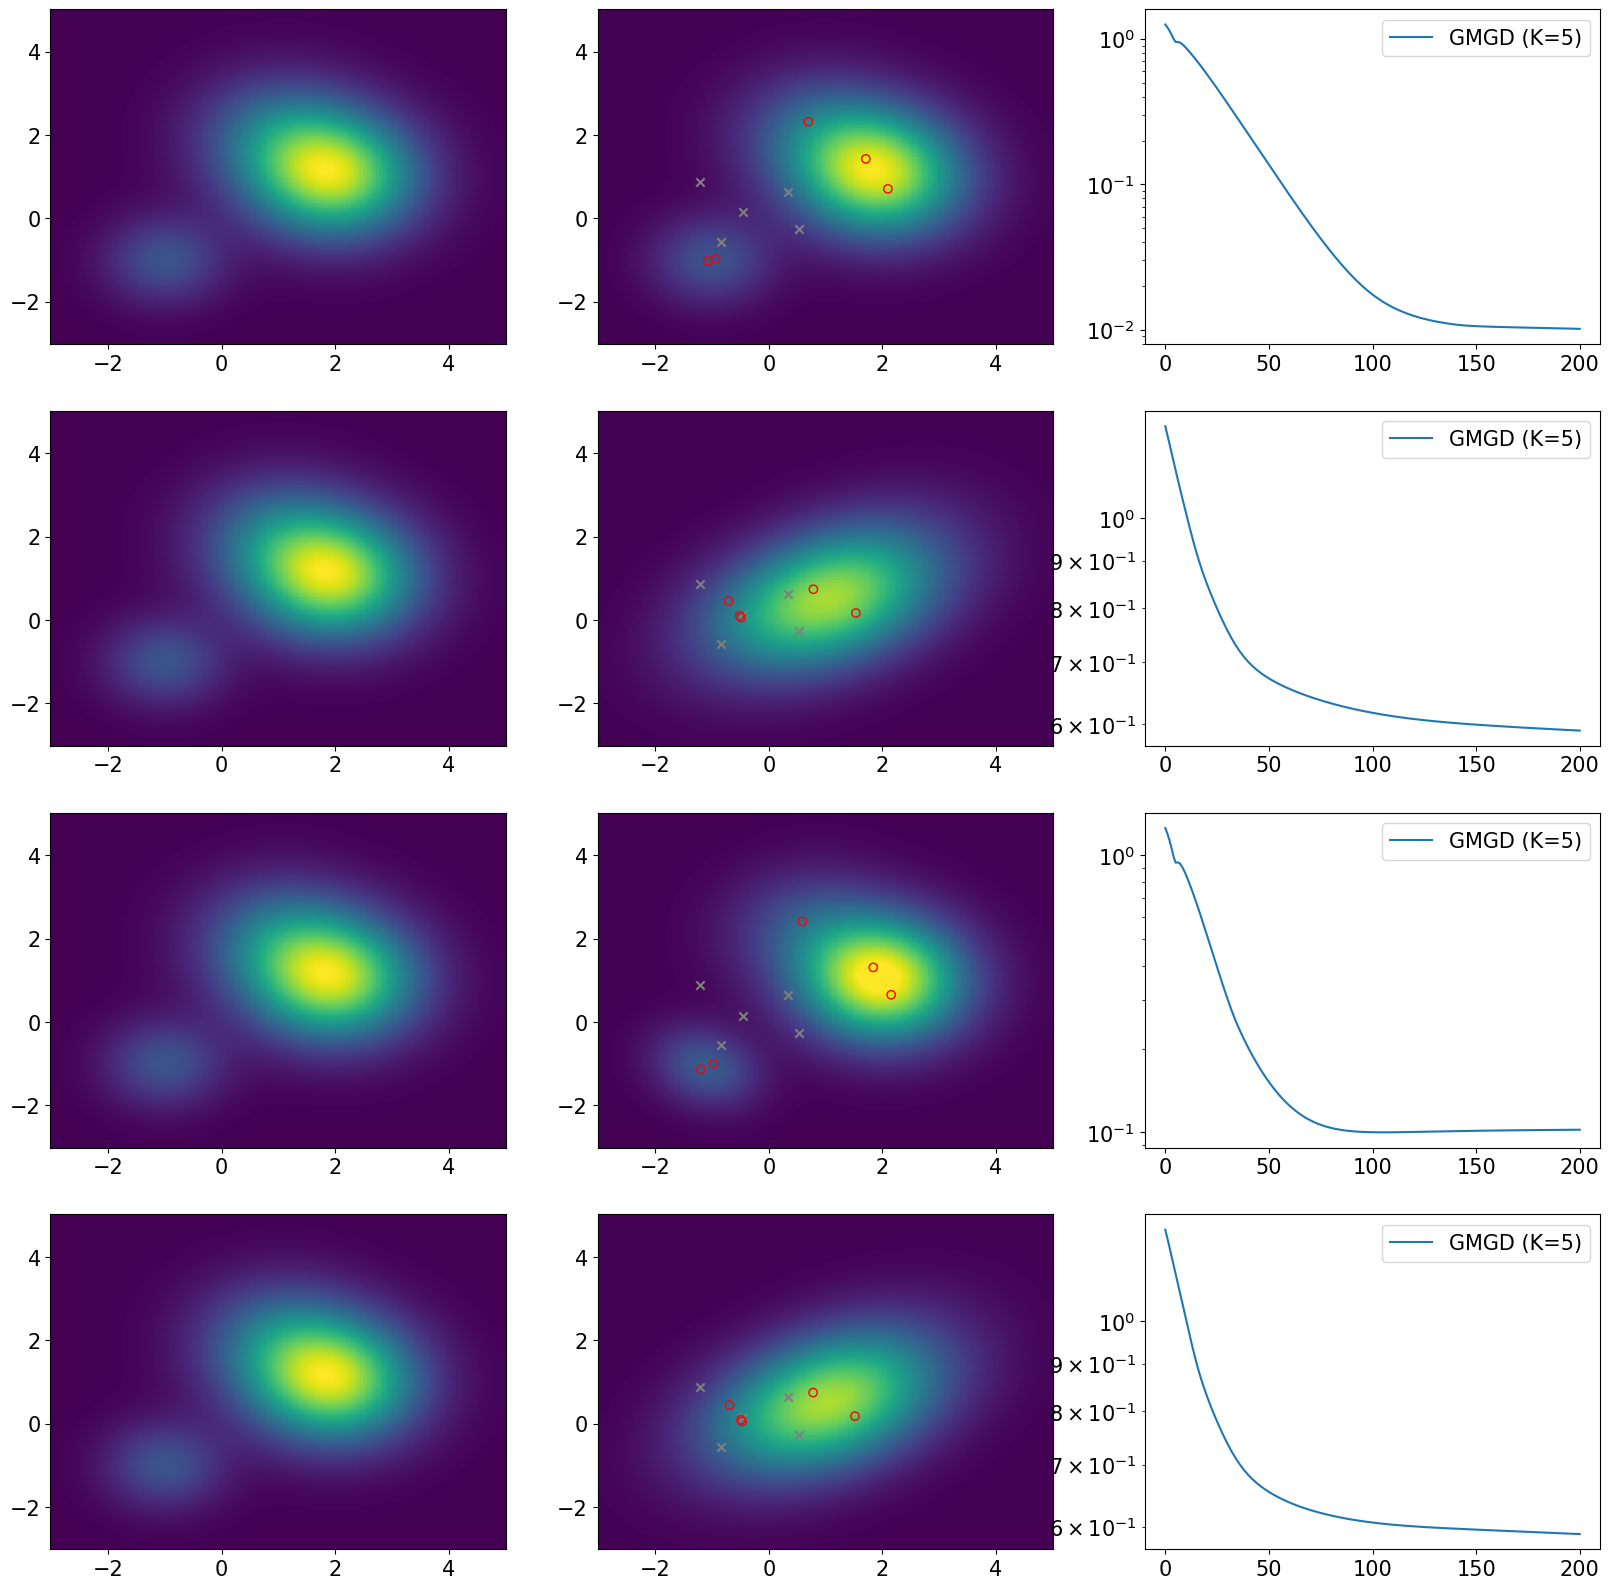

In [5]:
fig, ax = PyPlot.subplots(nrows=4, ncols=3, sharex=false, sharey=false, figsize=(20,20))

x_w_ref, x_mean_ref = [0.2;0.5;0.3], [1.0 2.0; 2.0 1.0; -1.0 -1.0]
N_modes_ref, N_x = size(x_mean_ref)
xx_cov_ref = zeros(N_modes_ref, 2, 2)
for im = 1:N_modes_ref
    xx_cov_ref[im,:,:] += I
end
xx_cov_ref[N_modes_ref,:,:] /= 2.0

inv_sqrt_x_cov_ref = [compute_sqrt_matrix(xx_cov_ref[im,:,:]; type="Cholesky")[2] for im = 1:N_modes_ref]
func_args = (x_w_ref, x_mean_ref, inv_sqrt_x_cov_ref)
func_dV(x) = Gaussian_mixture_V(x, func_args)
func_V(x) = -Gaussian_mixture(x, func_args)



Random.seed!(111);
N_modes = 5
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end


sqrt_matrix_type = "Cholesky"
N_iter , dt  = 200, 0.05
T =  N_iter * dt
quadrature_test_list = [
    ("mean_point","mean_point"),
    ("cubature_transform_o3","cubature_transform_o3"),
    ("cubature_transform_o5","mean_point"),
    ("cubature_transform_o5","cubature_transform_o3")]
for iobs = 1:length(quadrature_test_list)
    quadrature_type_GM, quadrature_type = quadrature_test_list[iobs]
    gmgdobj = GMGD_Run(
            func_dV, 
            T,
            N_iter,
            # Initial condition
            x0_w, x0_mean, xx0_cov;
            sqrt_matrix_type = sqrt_matrix_type,
            # setup for Gaussian mixture part
            quadrature_type_GM = quadrature_type_GM,
            # setup for potential function part
            Bayesian_inverse_problem = false, 
            quadrature_type = quadrature_type)

    # Gaussian mixture test
    visualization_2d(ax[iobs,:]; Nx = 200, Ny = 200, x_lim=[-3.0, 5.0], y_lim=[-3.0, 5.0], func_V = func_V, objs=(gmgdobj,))

end


## Gaussian likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
A \theta
+\eta \quad (A = I)
\qquad 
y = 
\begin{bmatrix}
0.0\\
1.0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - A \theta}{\sigma_\eta}$$

     

## Circle shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\theta^T A \theta
+\eta \quad (A = I)
\qquad 
y = 1
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 
\end{bmatrix} 
\end{align*} (\sigma_\eta = 0.3)
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 

$$F(\theta) = \frac{y - \theta^T A \theta}{\sigma_\eta}$$

     
     
## Banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\lambda(\theta_{(2)} -  \theta_{(1)}^2)\\
\theta_{(1)}
\end{bmatrix}
+\eta \quad (\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
0\\
1
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\sigma_\eta^2 I \qquad (\sigma_\eta = 0.3)
\end{align*}
$$

We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}F^TF}$ with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \lambda(\theta_{(2)} -  \theta_{(1)}^2)}{\sigma_\eta}\\
\frac{y_{(2)} - \theta_{(1)}}{\sigma_\eta}
\end{bmatrix}$$
     
     
## Double banana shape likelihood function

Consider the following inverse problem 

$$
\begin{align*}
y = 
\begin{bmatrix}
\log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)\\ 
\theta_{(1)}\\ 
\theta_{(2)}
\end{bmatrix}
+ \eta \quad(\lambda = 100)
\qquad 
y = 
\begin{bmatrix}
\log(\lambda+1)\\
0\\
0
\end{bmatrix}
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_\eta^2 & \\
& 1^2   \\
& & 1^2
\end{bmatrix}  
\end{align*}
$$

We essentially focus on the prior $\mathcal{N}(0,I)$, and we are sampling 
$e^{-\frac{1}{2}F^TF}$ 
with 
$$F(\theta) = 
\begin{bmatrix}
\frac{y_{(1)} - \log\Bigl(
\lambda(\theta_{(2)} -  \theta_{(1)}^2)^2 + (1 - \theta_{(1)})^2
\Bigr)}{\sigma_\eta}\\
y_{(2)} - \theta_{(1)}\\
y_{(3)} - \theta_{(2)}
\end{bmatrix}$$

In [6]:
function G(θ, arg, Gtype = "Gaussian")
    if Gtype == "Gaussian"
        A = arg
        return A*θ
    elseif Gtype == "Double_modes"
        return [(θ[1]- θ[2])^2 ; (θ[1] + θ[2])^2]
        
    elseif Gtype == "Circle"
        A = arg
        return [θ'A*θ]
    elseif Gtype == "Banana"
        λ = arg
        return [λ*(θ[2] - θ[1]^2); θ[1]]
    elseif Gtype == "Double_banana"
        λ = arg
        return [log( λ*(θ[2] - θ[1]^2)^2 + (1 - θ[1])^2 ); θ[1]; θ[2]]
    else
        print("Error in function G")
    end
end


function F(θ, args)
    y, ση, arg, Gtype = args
    Gθ = G(θ, arg, Gtype )
    return (y - Gθ) ./ ση
end

function info_F(Gtype)
    if Gtype == "Gaussian"
        N_θ, N_f = 2, 2
    elseif Gtype == "Double_modes"
        N_θ, N_f = 2, 2
    elseif Gtype == "Circle"
        N_θ, N_f = 2, 1
    elseif Gtype == "Banana"
        N_θ, N_f = 2, 2
    elseif Gtype == "Double_banana"
        N_θ, N_f = 2, 3
    else
        print("Error in function G")
    end
    
    return N_θ, N_f
end


function logrho(θ, args)
    Fθ = F(θ, args)
    return -0.5*norm(Fθ)^2
end


function V(θ, args)
    return -logrho(θ, args), 
           -ForwardDiff.gradient(x -> logrho(x, args), θ), 
           -ForwardDiff.hessian(x -> logrho(x, args), θ)
end



V (generic function with 1 method)

In [7]:
function Gaussian_mixture_VI(func_V, func_F, w0, μ0, Σ0; N_iter = 100, dt = 1.0e-3)

    N_modes, N_θ = size(μ0)
    

    
    T =  N_iter * dt
    N_modes = 1
    x0_w = w0
    x0_mean = μ0
    xx0_cov = Σ0
    sqrt_matrix_type = "Cholesky"
    
    objs = []

    if func_V !== nothing
#         gmgdobj = GMGD_Run(
#         func_V, 
#         T,
#         N_iter,
#         # Initial condition
#         x0_w, x0_mean, xx0_cov;
#         sqrt_matrix_type = sqrt_matrix_type,
#         # setup for Gaussian mixture part
#         quadrature_type_GM = quadrature_type_GM,
#         # setup for potential function part
#         Bayesian_inverse_problem = false, 
#         quadrature_type = "cubature_transform_o3")
        
        
        gmgdobj = GMGD_Run(
        func_V, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        sqrt_matrix_type = sqrt_matrix_type,
        # setup for Gaussian mixture part
        quadrature_type_GM = "mean_point",
        # setup for potential function part
        Bayesian_inverse_problem = false, 
        quadrature_type = "mean_point")
        
        push!(objs, gmgdobj)

    end

    if func_F !== nothing
        N_f = length(func_F(ones(N_θ)))
        gmgdobj_BIP = GMGD_Run(
        func_F, 
        T,
        N_iter,
        # Initial condition
        x0_w, x0_mean, xx0_cov;
        sqrt_matrix_type = sqrt_matrix_type,
        # setup for Gaussian mixture part
        quadrature_type_GM = "mean_point",
        # setup for potential function part
        Bayesian_inverse_problem = true, 
        N_f = N_f,
        quadrature_type = "unscented_transform",
        c_weight_BIP = 1.0e-3,
        w_min=1e-10)
        
        push!(objs, gmgdobj_BIP)

    end

    return objs
end




Gaussian_mixture_VI (generic function with 1 method)

In [ ]:
include("../Inversion/GMGD.jl")
fig, ax = PyPlot.subplots(nrows=5, ncols=4, sharex=false, sharey=false, figsize=(25,20))

    
Random.seed!(11);
#Random.seed!(111);
N_modes = 20
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end




N_iter = 1000
Nx, Ny = 100,100
ση = 1.0
Gtype = "Gaussian"
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[1,:]; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_F=func_F, objs=objs)



ση = 0.1
Gtype = "Double_modes"
y = [0.0; 1.0]
func_args = (y, ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[2,:]; Nx = Nx, Ny = Ny, x_lim=[-1.0, 1.0], y_lim=[-1.5, 1.5], func_F=func_F, objs=objs)



ση = 0.5
Gtype = "Circle"
A = [1.0 1.0; 1.0 2.0]
y = [1.0;]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[3,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)



ση = sqrt(10.0)
Gtype = "Banana"
λ = 10.0
y = [0.0; 1.0]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[4,:]; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 10.0], func_F=func_F, objs=objs)



ση = [0.3; 1.0; 1.0]
Gtype = "Double_banana"
λ = 100.0
y = [log(λ+1); 0.0; 0.0]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dV(x) = V(x, func_args)
objs = (Gaussian_mixture_VI(nothing, func_F, x0_w[1:div(N_modes,2)], x0_mean[1:div(N_modes,2),:], xx0_cov[1:div(N_modes,2),:,:]; N_iter = N_iter, dt = 1e-1)[1],
        Gaussian_mixture_VI(nothing, func_F, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = 1e-1)[1])
visualization_2d(ax[5,:]; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, objs=objs)

fig.tight_layout()
fig.savefig("DFGMGD.pdf")

[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("iter = ", 700, " / ", 1000)
[ Info: ("iter = ", 800, " / ", 1000)
[ Info: ("iter = ", 900, " / ", 1000)
[ Info: ("iter = ", 1000, " / ", 1000)
[ Info: ("iter = ", 100, " / ", 1000)
[ Info: ("iter = ", 200, " / ", 1000)
[ Info: ("iter = ", 300, " / ", 1000)
[ Info: ("iter = ", 400, " / ", 1000)
[ Info: ("iter = ", 500, " / ", 1000)
[ Info: ("iter = ", 600, " / ", 1000)
[ Info: ("